In [1]:
import os
import ogs6py
import vtuIO
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

## 1. Problem description

This benchmark is meant to model radionuclide migration through a semi-infinite column of undisturbed Opalinus Clay (OPA), which could potentially serve as a geological repository for radioactive waste. In this benchmark, Cesium ($^{135}$Cs) is chosen for investigation because it may be present in the repository if the disposal canister is ruptured. In view of the low hydraulic conductivity of OPA, Cesium migration is considered to be dominated by diffusion. Two additional processes are also considered, including (i) retardation resulting from solute sorption on the clay, and (ii) concentration attenuation caused by radioactive decay over time.

In the one-dimensional model setup, the mass balance equation for the diffusion-sorption-decay process is given as follows:

$$
\frac{\partial \left( \phi R c\right)}{\partial t} = \frac{\partial}{\partial x} \left(\phi \mathrm{D_p} \frac{\partial c}{\partial x} \right) - \phi \alpha R c,
$$

where $c$ [mol/m$^3$] represents the $^{135}$Cs concentration in this example, $\mathrm{D_p}$ [m$^2$/s] is the pore diffusion coefficient for $^{135}$Cs, $\phi$ [-] is the porosity of OPA, $R$ [-] is the retardation factor defined as

$$
R = 1 + \rho k_{d} / \phi,
$$

with the dry density of OPA $\rho$ [kg/m$^3$] and the distribution coefficient $k_d$ [m$^3$/kg], and $\alpha$ [1/s] is the first-order decay constant, i.e.:

$$
\alpha = \mathrm{ln} 2 \, / \, t_{1/2},
$$

where $t_{1/2}$ [s] is the half life of the diffusing radionuclide.

## 2. Model setups

Our simulation domain is set to be 20 meters long, which is sufficient to ensure that the concentration profile does not reach the right-hand boundary during simulation. The simulated time is one million years. Initially, the entire domain is assumed to be solute free, i.e., $c_{\mathrm{ini}}(x, 0) = 0$. The inlet concentration is held at 1 mol/L throughout the simulation, i.e., $c(0, t) = 1$ mol/L. The spatial domain is discretized by linear line elements with a length of 0.01 meter each. The time step size of one thousand years is used in the simulation. The linearized governing equation is iteratively solved using the Newton-Raphson method.

The table below summarizes the parameters used in the simulation.

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Porosity $\phi$ | 0.12 | - |
| Pore diffusion coefficient $\mathrm{D_p}$ | 8.33e-11 | m$^2$/s |
| OPA bulk density $\rho$ | 2394 | kg/m$^3$ |
| Distribution coefficient $k_{d}$ | 0.5 | m$^3$/kg |
| $^{135}$Cs half life $t_{1/2}$ | 2.3e6 | year |
| Time step size $\Delta t$ | 1e3 | year |
| Grid size $\Delta x$ | 0.01 | m|

Notes: The parameter values are sourced from Nagra (2002).

## 3. Results

**Analytical solution**

The time-dependent concentration profile can be analytically calculated as a function of $t$ and $x$. The analytical solution for this diffusion-soprtion-decay system is given in Carslaw and Jaeger (1959):

$$
c(x, t) = \frac{c_0}{2} \left\{ \mathrm{exp} \left[-x \left(\frac{\alpha R}{\mathrm{D_p}}\right)^{\frac{1}{2}} \right] \mathrm{erfc} \left[ \frac{x}{2} \left(\frac{R}{\mathrm{D_p}t}\right)^{\frac{1}{2}} - \left(\alpha t\right)^{\frac{1}{2}}\right] + \mathrm{exp} \left[x \left(\frac{\alpha R}{\mathrm{D_p}}\right)^{\frac{1}{2}} \right] \mathrm{erfc} \left[ \frac{x}{2} \left(\frac{R}{\mathrm{D_p}t}\right)^{\frac{1}{2}} + \left(\alpha t\right)^{\frac{1}{2}}\right]\right\}
$$

Below a python script is presented, through which the concentration profiles can be analytically calculated at any time.

Here the concentration profiles are illustrated at $t$ = 10$^3$, 10$^4$, 10$^5$, and 10$^6$ years.

In [2]:
###Model parameters###
#Effective diffusion coefficient [m2/s]
De = 1e-11
#Porosity [-]
phi = 0.12
#Pore diffusion coefficient [m2/s]
Dp = De / phi
#Porous medium bulk density [kg/m3]
rho = 2.394e3
#Distribution coefficient [m3/kg]
Kd = 0.5
#135-Cs Half-life [year]
half_life = 2.3e6
#Decay constant [1/s]
alpha = np.log(2)/half_life/3.1536e7 # unit conversion from year to second

###Spatial and temporal discretization###
#Distance [m]
x = np.linspace(0, 2, num=201)
#Time [year]
time = np.array([1e3, 1e4, 1e5, 1e6])

###Initial condition and boundary conditions###
#Initial condition [mol/L]
c_ini = 0
#Inlet concentration [mol/L]
c_inlet = 1

###Intermediate parameters###
#Retardation factor [-]
R = 1 + rho*Kd/phi

###Analytical solution###
c = np.empty((0, x.size))
for t in time*3.1536e7: #unit conversion from year to second
    c_t = c_inlet/2*(np.exp(-x*(alpha*R/Dp)**0.5)*special.erfc(x/2*(R/Dp/t)**0.5-(alpha*t)**0.5) \
               + np.exp(x*(alpha*R/Dp)**0.5)*special.erfc(x/2*(R/Dp/t)**0.5+(alpha*t)**0.5))
    c = np.vstack([c, c_t])

The analytically computed $^{135}$Cs concentration profiles at $t$ = 10$^3$, 10$^4$, 10$^5$, and 10$^6$ years are plotted as shown in the figure below.

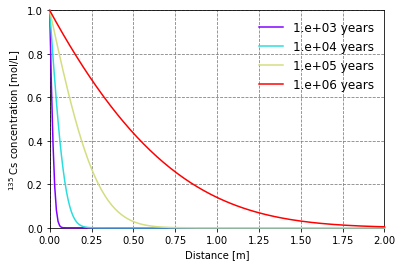

In [3]:
#plot analytical solution
def plot_analytical_solutions():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,2))
    ax.set_ylim((0,1))
    
    plt.xlabel('Distance [m]')
    plt.ylabel('$^{135}$ Cs concentration [mol/L]')

    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))
    
    for c_t, t, color in zip(c, time, color_map):
        ax.plot(x, c_t, linestyle='-', lw=1.5,
                label=str(np.format_float_scientific(t))+' years',
                c=color, zorder=10, clip_on=False)
    
    ax.legend(frameon=False, loc='upper right', numpoints=1, 
              fontsize=12, ncol=1)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
plot_analytical_solutions()    

**Numerical solution**

Correspondingly, the OGS input files of this 1D mass transport model can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/DiffusionSorptionDecay/DiffusionSorptionDecay.prj">here</a>.

Then, the numerical solution of OpenGeoSys is plotted against the analytical solution for comparison.

In [5]:
#Run OGS simulation
prj_name = "1D_DiffusionSorptionDecay"
data_dir = os.environ.get('OGS_DATA_DIR', '../../../Data')
prj_file = f"{data_dir}/Parabolic/ComponentTransport/DiffusionSorptionDecay/{prj_name}.prj"
out_dir = os.environ.get('OGS_TESTRUNNER_OUT_DIR', '_out')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)

print(f"ogs {prj_file} > out.txt")
! ogs {prj_file} > out.txt

#Read simulation results
pvdfile = vtuIO.PVDIO(f"{prj_name}.pvd", dim=1)

def plot_simulation_results():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,2))
    ax.set_ylim((0,1))
        
    plt.xlabel('Distance [m]')
    plt.ylabel('$^{135}$ Cs concentration [mol/L]')
    
    color_map = iter(cm.rainbow(np.linspace(0,1,len(time))))
    #Plot analytical solutions 
    for c_t, color in zip(c, color_map):
        ax.plot(x, c_t, linestyle='-', lw=1.5,
                c=color, zorder=10, clip_on=False)
        
    #Add simulation results
    color_map=iter(cm.rainbow(np.linspace(0,1,len(time))))
    for t, color in zip(time, color_map):
        c_t = pvdfile.read_set_data(t*3.1536e7, 'Cs', data_type="point", pointsetarray=[(i,0,0) for i in x])
        plt.plot(x, c_t, label="Sim. "+str(np.format_float_scientific(t))+' years', 
                 color=color, marker='o', markevery=5, linestyle="", zorder=10, clip_on=False)
    
    ax.legend(frameon=False, loc='upper right', numpoints=1, 
              fontsize=12, ncol=1)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')
    
plot_simulation_results()    

TypeError: __init__() missing 1 required positional argument: 'filename'

In the figure above, it can be seen that the numerical profiles and analytical solutions agree well at different times.

**Error estimation**

To evaluate the accuracy of numerical solution, the Euclidean norm of the approximate solution error $|| \mathbf{c} - \mathbf{c}^{\mathrm{exact}}||_{2} = \left(\sum\mathop{}_{\mkern-5mu i} |c_i - c_{i}^{\mathrm{exact}}|^2 \right)^{1/2}$ over the entire domain is calculated based on the exact analytical solution $\mathbf{c}^{\mathrm{exact}}$.

In [ ]:
l2_norm_error = np.empty((0, 1))

for c_ext, t in zip(c, time):
    c_sim = pvdfile.read_set_data(t*3.1536e7, 'Cs', data_type="point", pointsetarray=[(i,0,0) for i in x])
    
    l2_norm_error_t = np.log10(np.sum((c_sim - c_ext)**2)**0.5)
    l2_norm_error = np.vstack([l2_norm_error, l2_norm_error_t])

In [ ]:
def plot_l2_norm_error():
    fig, ax = plt.subplots()
    
    ax.set_xlim((0,1e6))
    ax.set_ylim((-4,0))
    
    plt.xlabel('Time [year]')
    plt.ylabel('Log $||\mathbf{c}-\mathbf{c^{exact}}||_{2}$')
    
    ax.plot(time, l2_norm_error, linestyle='-', lw=1.5, 
            marker='o', zorder=10, clip_on=False)
    
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.yaxis.grid(color='gray', linestyle='dashed')

In [ ]:
plot_l2_norm_error()

As the simulation time increases, the L$_2$ error norm decreases rapidly and evenually drops down to 10$^{-3}$.

## References

<a href="https://www.nagra.ch/de/technical-report-02-06">Nagra, 2002.</a> Project Opalinus Clay: Models, Codes and Data for Safety Assessment. Technical Report NTB 02–06. Nagra, Switzerland.

Carslaw, H. S. & Jaeger, J. C., 1959: Conduction of heat in solids. 2nd Ed., Oxford Science Publications, Clarendon
Press, Oxford, UK.

Van Genuchten, M.T., 1981. Analytical solutions for chemical transport with simultaneous adsorption, zero-order production and first-order decay. Journal of hydrology, 49(3-4), pp.213-233.

**Credits:**

Renchao Lu, Jaime Garibay-Rodriguez, Lars Bilke, Christoph Lehmann, Haibing Shao